In [1]:
import math
import sqlite3
from html import escape
from itertools import groupby
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.core.display import HTML
from docutils.core import publish_parts

%matplotlib inline
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('compression.db')

In [3]:
def render_rst(rst):
    """
    Given reStructuredText *rst*, return the rendered HTML
    content, excluding the surrounding outer-most ``<body>``
    elements.
    """
    return publish_parts(rst, writer_name='html')['html_body']

In [4]:
HTML(render_rst(Path('README.rst').read_text()))

Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


## Analysis Functions

Before performing the analysis itself, we define some convenience functions for
rendering the output of an SQL query against the database as HTML, and for
rendering certain queries as X-Y scatter graphs.

In [5]:
def render_table(cur):
    """
    Given *cur*, a cursor containing a database result set, return a
    string containing the result set rendered as an HTML ``<table>``
    element.
    """
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header).replace('_', ' ').title())}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>"""

In [6]:
def transpose(seq):
    return list(zip(*seq))

def render_xy(cur, ax=None, x_label='', y_label='', legend=True):
    """
    Given *cur*, a cursor containing a database result set, plot the
    results on an X-Y scatter graph on axes *ax*. The cursor is expected
    to contain at least 2 columns named "x" and "y".
    
    Optionally, a third column named "category" may be included which
    will be used to plot different coloured items. If this is used, the
    result set must be ordered by the category column.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    if ax is None:
        ax = plt.axes()
    cols = [c[0] for c in cur.description]
    x_col = cols.index('x')
    y_col = cols.index('y')
    getter = itemgetter(x_col, y_col)
    if 'category' in cols:
        cat_col = cols.index('category')
        data = {}
        for category, values in groupby(cur, key=itemgetter(cat_col)):
            results = transpose(getter(row) for row in values)
            ax.plot(results[0], results[1], label=category, **style)
        if legend:
            ax.legend()
    else:
        results = transpose(getter(row) for row in cur)
        ax.plot(results[0], results[1], **style)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    return ax

In [7]:
def render_xyz(cur, fig=None, x_label='', y_label='', z_label='',
               legend=True):
    """
    Given *cur*, a cursor containing a database result set, plot the
    results on three X-Y scatter graphs. The cursor is expected
    to contain at least 3 columns named "x", "y", "z". The "x" and "y"
    columns will be plotted on the "common" graph, with "x" and "z"
    being plotted below the common graph, and "y" and "z" being plotted
    to the right of the common graph.
    
    Optionally, a fourth column named "category" may be included which
    will be used to plot different coloured items. If this is used, the
    result set must be ordered by the category column.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    if fig is None:
        fig = plt.figure(figsize=(10 ,10))
    axs = fig.subplots(2, 2)
    cols = [c[0] for c in cur.description]
    cur = list(cur)
    labels = {
        'x': x_label,
        'y': y_label,
        'z': z_label,
    }
    for ax, ax_cols in zip(axs.flat, ('xy', 'zy', 'xz')):
        getter = itemgetter(
            cols.index(ax_cols[0]),
            cols.index(ax_cols[1]))
        if 'category' in cols:
            cat_col = cols.index('category')
            data = {}
            for category, values in groupby(cur, key=itemgetter(cat_col)):
                results = transpose(getter(row) for row in values)
                ax.plot(results[0], results[1], label=category, **style)
            if legend:
                ax.legend()
        else:
            results = transpose(getter(row) for row in cur)
            ax.plot(results[0], results[1], **style)
        ax.set_xlabel(labels[ax_cols[0]])
        ax.set_ylabel(labels[ax_cols[1]])
    axs[1, 1].set(visible=False)
    return fig

## Analysis Results

### Combinations tested

A list of all the machines (and architectures) tested:

In [8]:
HTML(render_table(conn.execute("""
SELECT DISTINCT machine, arch
FROM results
""")))

Machine,Arch
AMD Ryzen 32GB,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2 512MB,arm64
Pi Zero 2 512MB,armhf


A list of all the compressors and options tested:

In [9]:
HTML(render_table(conn.execute("""
SELECT compressor, options, GROUP_CONCAT(level) AS levels
FROM tests
GROUP BY compressor, options
ORDER BY compressor, options
""")))

Compressor,Options,Levels
bzip2,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
bzip2,-s,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
gzip,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,,"-1,-10,-11,-12,-2,-3,-4,-5,-6,-7,-8,-9"
lzip,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,-e,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,-T0,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"


Notes:
* The `-e` option for `xz` enables "extreme" (!) compression
* The `-s` option for `bzip2` reduces memory usage
* The `-T0` option for `zstd` enables multi-threaded operation

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [10]:
HTML(render_table(conn.execute("""
SELECT machine, arch, compressor, options, level
FROM results
WHERE succeeded = 0
""")))

Machine,Arch,Compressor,Options,Level
Pi Zero 2 512MB,arm64,xz,,-7
Pi Zero 2 512MB,arm64,xz,,-8
Pi Zero 2 512MB,arm64,xz,,-9
Pi Zero 2 512MB,arm64,xz,-e,-7
Pi Zero 2 512MB,arm64,xz,-e,-8
Pi Zero 2 512MB,arm64,xz,-e,-9
Pi Zero 2 512MB,arm64,zstd,,-16
Pi Zero 2 512MB,arm64,zstd,,-17
Pi Zero 2 512MB,arm64,zstd,,-18
Pi Zero 2 512MB,arm64,zstd,,-19


From the table above we can see that only the Pi Zero 2 has an issue, and that
only the more aggressive options of ``xz`` and ``zstd`` tend to cause a direct
failure. However, it's worth bearing in mind that these tests were run on
otherwise idle and unloaded systems. We should strive to be as minimal as
possible in both memory and time usage because:

* The more memory we use, the more chance of pushing other services into OOM
  failure. For example, on the Pi Zero 2 (and 3A+) with the arm64 architecture,
  the typical amount of RAM available at runtime with all "default" services
  loaded is only around 200MB. If our compressor takes 50MB of RAM, and a daemon
  is running that takes 100MB of RAM we're at serious risk of pushing the daemon
  into the waiting arms of the OOM killer.

* The more time we use, the more we risk being terminated prematurely. Consider
  that `unattended-upgrades` runs by default and that a kernel upgrade could
  well be running at shutdown time. If our compressor takes 4 minutes to run
  we're at serious risk of the user just pulling the plug (no one waits 4
  minutes for shutdown!).

## Useful combinations

From the above we can rule out certain compressor options (`zstd` above -10,
`xz` above -6, etc). However, we should have a general overview of how these
compressors fare against each other to see whether one is obviously "better"
than the others, and whether any are sufficiently inferior that we can discard
them immediately.

The following graphs show three data-points, time taken to compress, memory used
to compress, and compression size achieved (in %) all plotted against each other
for a given machine and architecture:

In [11]:
machines_archs = list(
    conn.execute("SELECT DISTINCT machine, arch FROM results"))

In [20]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{machine} ({arch})', (machine, arch))
        for machine, arch in machines_archs
    ],
    value=('AMD Ryzen 32GB', 'amd64'),
    description='Select a machine'
))
def compare_compressors(value):
    machine, arch = value
    query = """
    SELECT
      comp_duration AS x,
      comp_max_mem / 1048576 AS y,
      100 * CAST(output_size AS FLOAT) / input_size AS z,
      compressor AS category
    FROM results
    WHERE succeeded = 1
    AND machine = ?
    AND arch = ?
    ORDER BY category
    """
    render_xyz(conn.execute(query, (machine, arch)),
               x_label='Elapsed (s)',
               y_label='Max. resident size (MB)',
               z_label='Compressed size (%)')
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


          1         2         3         4         5         6         7         8
012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789
                                                                                |



Playing around with the data, several conclusions should become obvious:

1. `bzip2` is slow, yet typically produces output larger than faster algorithms
   (run at lower compression levels). This suggests we should discard it from
   further consideration

1. `xz`, `lzip`, and `zstd` all use huge amounts of memory at their higher
   levels. It's telling that the Pi Zero 2 values top out at 175MB, while other
   platforms top out above 500MB. This is simply because any levels taking more
   than 175MB on the Pi Zero 2 got OOM killed

1. That said, the LZMA-based compressors (`xz` and `lzip`) consistently produce
   the best compression ratios. The newer `zstd` is a very close competitor and
   is significantly faster, but uses equally huge amounts of memory (possibly
   more at lower levels), and never *quite* reaches the best ratios of the the
   LZMA-based compressors

1. By contrast, `gzip`, `lz4`, and `bzip2` (maybe?) all appear to be O(1)
   algorithms space-wise. While the `bzip2` algorithm is already discarded due
   to its relatively poor compression/time performance, it's still clearly the
   most powerful compressor amongst the fixed-memory algorithms

Let's confirm some of these conclusions by looking at individual compressor
option combinations:

In [21]:
compressor_options = list(
    conn.execute("SELECT compressor, options FROM options"))

In [25]:
@widgets.interact(value=widgets.Dropdown(
    options=[
        (f'{compressor} {options}', (compressor, options))
        for compressor, options in compressor_options
    ],
    value=('bzip2', ''),
    description='Select a compressor'
))
def compare_compressors(value):
    compressor, options = value
    query = """
    SELECT
      comp_duration AS x,
      comp_max_mem / 1048576 AS y,
      100 * CAST(output_size AS FLOAT) / input_size AS z,
      machine || ' (' || arch || ')' AS category
    FROM results
    WHERE succeeded = 1
    AND compressor = ?
    AND options = ?
    ORDER BY category
    """
    render_xyz(conn.execute(query, (compressor, options)),
               x_label='Elapsed (s)',
               y_label='Max. resident size (MB)',
               z_label='Compressed size (%)')
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


If you compare some of the compressor options above you'll discover:

* Only `bzip2 -s` is actually constant memory (`bzip2` by default varies in memory usage, although over a relatively narrow range). By constrast, `lz4` and `gzip` are *always* constant memory



## Compression comparisons

A quick look at how well the various options perform. We'll query only those
combinations that succeeded, limited to those that took less than 20s (otherwise
`xz` squishes everything into a corner!), categorize by the compressor, and
limit output to a single machine (and architecture) per graph (with shared axes)
at a time for ease of comparison:

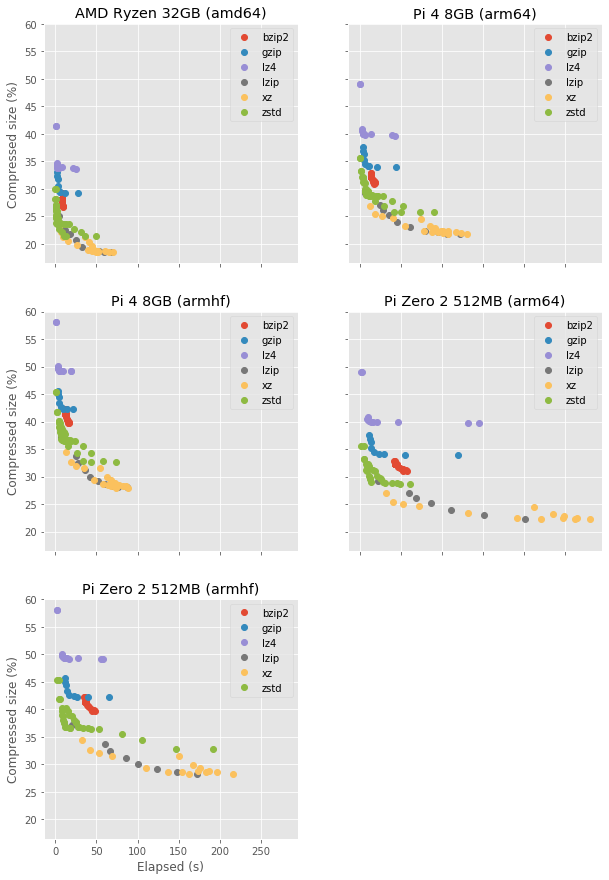

In [13]:
query = """
SELECT
  comp_duration AS x,
  100 * CAST(output_size AS FLOAT) / input_size AS y,
  compressor AS category
FROM results
WHERE succeeded = 1
AND machine = ?
AND arch = ?
--AND comp_duration < 20
ORDER BY compressor
"""
fig, axs = plt.subplots(
    len(machines_archs) // 2 + len(machines_archs) % 2, 2,
    figsize=(10, 15), sharex=True, sharey=True)
for ax, (machine, arch) in zip(axs.flat, machines_archs):
    render_xy(conn.execute(query, (machine, arch)), ax=ax,
              x_label='Elapsed (s)',
              y_label='Compressed size (%)')
    ax.set_title(f'{machine} ({arch})')
    ax.label_outer()
if len(machines_archs) % 2:
    axs.flat[-1].set(visible=False)

From the above, we can conclude:

* The patterns are fairly obvious: higher compression takes more time; each
  "sweep" of dots indicates a predictable continuum from `-1` up to `-9` (or
  whatever the range of compression levels are for a given compressor)

* `xz` is hopelessly slow; almost all its points are missing as they take more
  than 20s even on large-scale PCs, and even at minimal compression levels

* `lz4` was probably a mis-step. Whilst it's extremely fast at the `-1` end, it
  was hard-coded in `update-initramfs` with `-9` and at that level, even
  `gzip -1` beats it at compression, and is considerably faster

* `zstd -1` beats the compression ratio of `gzip` at most levels, and is within
  spitting distance of `lz4 -1` for speed (and consistently faster than
  `lz4 -2`)

## Memory pressure

How about the maximum resident size of each compressor at various levels? We'll
discount `xz` from the analysis as it's already rejected by the analysis above,
and limit the query to anything less than 100MB (otherwise `zstd` squashes
everything into a corner, particularly when running multi-threaded):

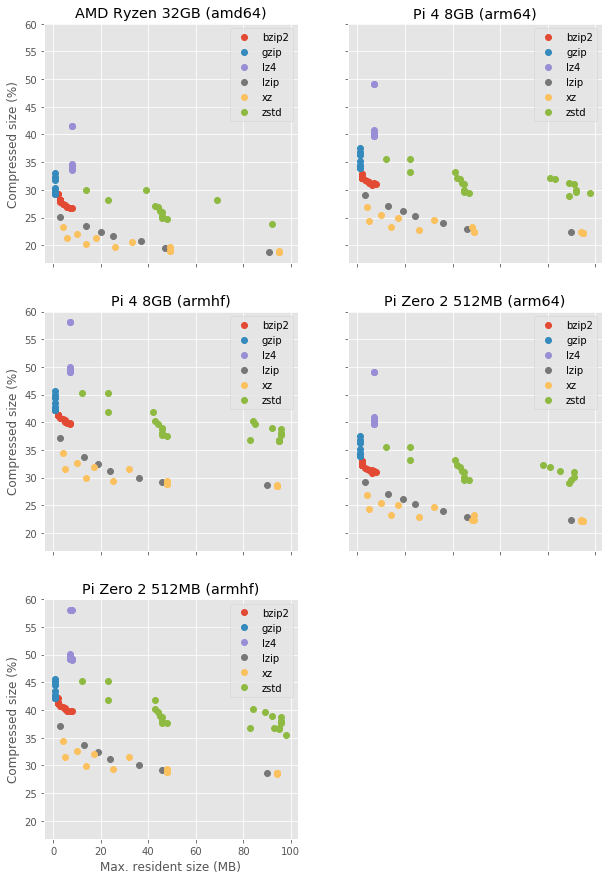

In [14]:
query = """
SELECT
  comp_max_mem / 1048576 AS x,
  100 * CAST(output_size AS FLOAT) / input_size AS y,
  compressor AS category
FROM results
WHERE succeeded = 1
AND machine = ?
AND arch = ?
AND comp_max_mem < 104857600
--AND compressor <> 'xz'
ORDER BY compressor
"""
fig, axs = plt.subplots(
    len(machines_archs) // 2 + len(machines_archs) % 2, 2,
    figsize=(10, 15), sharex=True, sharey=True)
for ax, (machine, arch) in zip(axs.flat, machines_archs):
    render_xy(conn.execute(query, (machine, arch)), ax=ax,
              x_label='Max. resident size (MB)',
              y_label='Compressed size (%)')
    ax.set_title(f'{machine} ({arch})')
    ax.label_outer()
if len(machines_archs) % 2:
    axs.flat[-1].set(visible=False)

`lz4` and `gzip` both clearly use O(1) algorithms with respect to space, no matter what compression level has been selected, or the size of the input (the uncompressed initrds used on each platform varied in size from 60MB on the armhf Pi images up to 120MB on the amd64 images). Interestingly, `gzip` is also the "safest" implementation (at least from a memory usage perspective), using the smallest RSS.

`zstd` by contrast varies over an extremely wide range depending on the level selected, and the size of the input, only approaching the smaller resident sizes of `lz4` and `gzip` at the smallest levels. However, it also achieves notable compression gains over `lz4` (and `gzip`, mostly) even at those low levels. Although not shown in the graphs above, `xz` displayed similarly variable behaviour.

## Decompression comparisons

Having seen that `gzip` has the most favourable combination of memory usage, compression ratio achieved, and duration required at least on the smaller platforms, is there any advantage to `lz4` at all? For example, given that decompression is expected to be a more regular activity that compression, if `lz4` decompression is considerably faster than it may overcome any lack of compression ratio achieved.

The graph below looks at elapsed time for decompression against the compression ratio that was achieved:

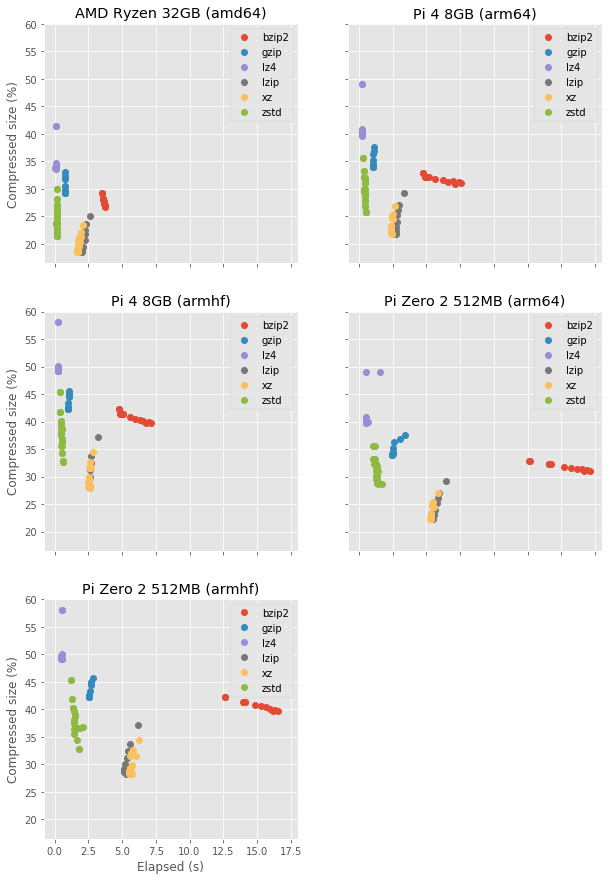

In [16]:
query = """
SELECT
  decomp_duration AS x,
  100 * CAST(output_size AS FLOAT) / input_size AS y,
  compressor AS category
FROM results
WHERE succeeded = 1
AND machine = ?
AND arch = ?
ORDER BY compressor
"""
fig, axs = plt.subplots(
    len(machines_archs) // 2 + len(machines_archs) % 2, 2,
    figsize=(10, 15), sharex=True, sharey=True)
for ax, (machine, arch) in zip(axs.flat, machines_archs):
    render_xy(conn.execute(query, (machine, arch)), ax=ax,
              x_label='Elapsed (s)',
              y_label='Compressed size (%)')
    ax.set_title(f'{machine} ({arch})')
    ax.label_outer()
if len(machines_archs) % 2:
    axs.flat[-1].set(visible=False)

We can immediately see that both `lz4` and `zstd` are considerably faster than the older implementations (`gzip` and `xz`). 

## Automation

Would it be possible to design some algorithm that, given an architecture and perhaps a memory size, selects an appropriate compression level (and possibly algorithm) automatically? My gut feeling is "no", and further that, even if the answer were "maybe", the result would be a maintenance nightmare. Still, let's see if there's any discernable pattern in the overall data anyway:

In [ ]:
query = """
SELECT
    comp_duration AS x,
    100 * CAST(output_size AS INTEGER) / input_size AS y,
    compressor AS category
FROM results
WHERE succeeded = 1
AND compressor <> 'xz'
AND comp_duration < 20
ORDER BY compressor
"""
render_xy(conn.execute(query),
          x_label='Elapsed (s)',
          y_label='Compression ratio')

From the above there is a pattern, but with sufficient overlap in the performance of various compressors at various levels that any automatic algorithm would have to be per-architecture and possibly per-machine-size. That would either involve a corpus of data (which would need to be maintained in the face of advances in technology), or similar tuning parameters (which likewise would require future maintenance).

## Limits

Some additional queries to flesh out my general impression that `zstd -1` is by far the most preferable compression default:

In [ ]:
HTML(render_table(conn.execute("""
WITH comp_filter(compressor, options, level) AS (
    VALUES
        ('zstd', '', '-1'),
        ('zstd', '', '-19'),
        ('lz4', '', '-9')
)
SELECT
    compressor,
    level,
    MIN(comp_duration) AS best_speed,
    MAX(comp_duration) AS worst_speed,
    MIN(ratio) AS best_ratio,
    MAX(ratio) AS worst_ratio
FROM
    results
    JOIN comp_filter USING (compressor, options, level)
WHERE succeeded = 1
GROUP BY compressor, level
ORDER BY compressor DESC, level ASC
""")))

`zstd -1` has a best time of less than a second, and a worst of no more than 5s, and it varies between compressing to roughly 30-45% of the original size.

Compare this to the prior defaults of `lz4 -9` and `zstd -19`, and bear in mind the above is across *all* architectures. The worst time of `zstd -1` (presumably on the little Pi Zero 2) is still better than the best time of `lz4 -9` (on the big fat AMD Ryzen), and while we do potentially sacrifice some compression ratio, it's still typically better than the prior `lz4 -9` default. But let's answer that more specifically:

Are there specific cases where the compression ratio of `zstd -1` is worse than `lz4 -9`, or where the elapsed time is slower?

In [ ]:
HTML(render_table(conn.execute("""
WITH lz4_9 AS (
    SELECT * FROM results
    WHERE compressor = 'lz4' AND level = '-9'
),
zstd_1 AS (
    SELECT * FROM results
    WHERE compressor = 'zstd' AND options = '' AND level = '-1'
)
SELECT
    l.machine, l.arch,
    l.ratio, z.ratio,
    l.comp_duration, z.comp_duration
FROM lz4_9 AS l JOIN zstd_1 AS z USING (machine, arch)
WHERE l.ratio < z.ratio
OR l.comp_duration < z.comp_duration
""")))

Nope!

## Conclusion

It's indisputable that `zstd -19` provides the best compression of our available options, but it does so at the cost of a pretty extraordinary amount of memory usage (particularly compared to its forebears), making it unsafe on the smaller platforms.

Whilst it may be tempting to try and eek every last byte of compression out of the system, doing so would also impose a maintenance cost and, in light of the results above, I believe a considerable one. By comparison, switching to `zstd -1` is a win in elapsed time, memory used, and compression achieved (at least compared to the prior `lz4 -9` default).